In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



In [7]:
# 1. Coleta de dados
ticker = "ITSA4.SA"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31")
df = df[['Close']]


/var/folders/nj/4s1r4fw96xjgpdh27hq9g6xr0000gn/T/ipykernel_24416/1228982624.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [11]:
# 2. Normalização
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)


# 3. Criar janelas (ex: 60 dias -> próximo dia)

In [15]:

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(df_scaled, window_size)

# 4. Reshape para LSTM (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 5. Divisão treino/teste (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [19]:

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print(f"\nMAPE: {mape:.2%}")

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0563 - val_loss: 0.0021
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

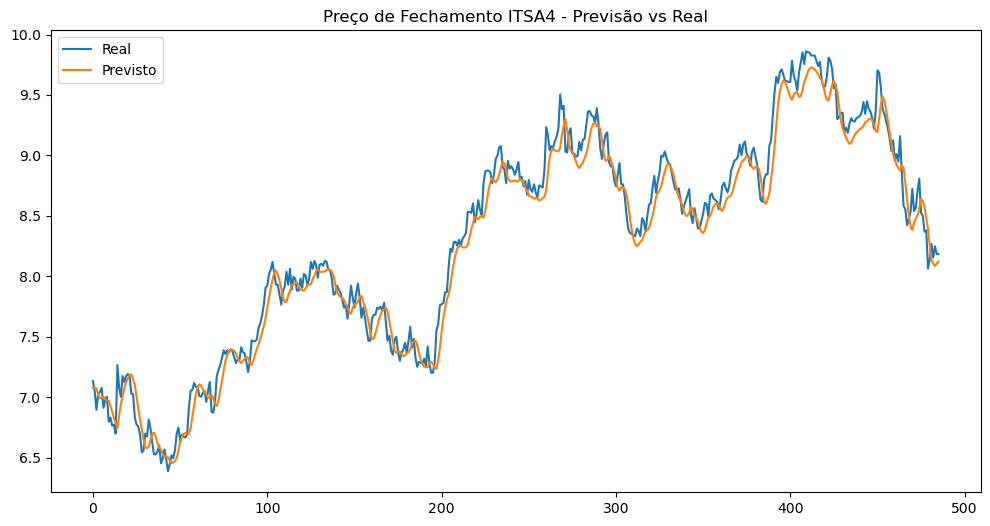

In [25]:
# 9. Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Real")
plt.plot(y_pred_inv, label="Previsto")
plt.legend()
plt.title("Preço de Fechamento ITSA4 - Previsão vs Real")
plt.show()




In [27]:
# 10. Salvar modelo
model.save("itausa_model.h5")

In [43]:
pip install prometheus-fastapi-instrumentator


Note: you may need to restart the kernel to use updated packages.
